# GossipCop dataset - Fake new detection

In [21]:
# IMPORT

# Base libraries
import pandas as pd
import numpy as np

# NLP preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

# Split and feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

# Plot
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Set random seed
RANDOM_SEED = 1234

## Preprocessing

### Loading the data and descriptive statisitics

In [22]:
# File paths
gossipcop_fake_path = 'GossipCop/gossipcop_fake.csv'
gossipcop_real_path = 'GossipCop/gossipcop_real.csv'


# Load the data
gossipcop_fake = pd.read_csv(gossipcop_fake_path)
gossipcop_real = pd.read_csv(gossipcop_real_path)


# Label the data
gossipcop_fake['is_real'] = 0
gossipcop_real['is_real'] = 1


# Merge the two datasets (fake+real)
gossipcop_df = pd.concat([gossipcop_fake, gossipcop_real], axis=0, ignore_index=True)


# Remove unnecessary features from the dataset
gossipcop_df.columns
gossipcop = gossipcop_df.drop(columns=['id', 'news_url', 'tweet_ids'])

In [23]:
# Rename the 'title' column to 'text'
gossipcop.rename(columns={'title': 'text'}, inplace=True)

In [24]:
# Drop news duplicates
gossipcop = gossipcop.drop_duplicates()

In [25]:
# Head of the dataset 
gossipcop.head(10)

,text,is_real
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0
2,Celebrities Join Tax March in Protest of Donal...,0
3,Cindy Crawford's daughter Kaia Gerber wears a ...,0
4,Full List of 2018 Oscar Nominations – Variety,0
5,Here's What Really Happened When JFK Jr. Met P...,0
6,Biggest celebrity scandals of 2016,0
7,Caitlyn Jenner Addresses Rumored Romance With ...,0
8,Taylor Swift Reportedly Reacts To Tom Hiddlest...,0
9,"For The Love Of God, Why Can't Anyone Write Ka...",0


In [26]:
# Shape of data object
gossipcop.shape

(20863, 2)

In [27]:
# Info about data object
gossipcop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20863 entries, 0 to 22139
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     20863 non-null  object
 1   is_real  20863 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 489.0+ KB


In [28]:
# Column names of dataframe
gossipcop.columns

Index(['text', 'is_real'], dtype='object')

### Missing values

In [29]:
# Check how many missing values there are in the dataset
gossipcop.isnull().sum().sum()

0

In [30]:
# Check unique values of the label ('is_fake') cloumn
print(gossipcop['is_real'].unique())

[0 1]


In [31]:
# Number of instances with label ('is_fake') 0 and 1
gossipcop["is_real"].value_counts()

1    15967
0     4896
Name: is_real, dtype: int64

### Preparing data for analysis

#### Tokenization

In [32]:
# Create new column with tokens
gossipcop['tokens'] = gossipcop.apply(lambda row: word_tokenize(row['text']), axis=1)

#### Lemmatization

In [33]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()


# Create new column with lemmas
gossipcop['lemma'] = gossipcop.apply(lambda row: [lemmatizer.lemmatize(token.lower()) for token in row["tokens"]], axis=1)

#### Stopword removal

In [34]:
# Load the english stopwords
english_stop_words = stopwords.words('english')


# Create new column without stopwords
gossipcop['stopword'] = gossipcop.apply(lambda row: [token for token in row["lemma"] if token not in english_stop_words], axis=1)

#### Final string creation

In [35]:
# Create new column with joined tokens (as TD-IDF takes a string as input)
gossipcop['final'] = gossipcop.apply(lambda row: " ".join(row['stopword']), axis=1)

In [36]:
# Head of the created dataaset
gossipcop.head()

,text,is_real,tokens,lemma,stopword,final
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0,"[Did, Miley, Cyrus, and, Liam, Hemsworth, secr...","[did, miley, cyrus, and, liam, hemsworth, secr...","[miley, cyrus, liam, hemsworth, secretly, get,...",miley cyrus liam hemsworth secretly get married ?
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0,"[Paris, Jackson, &, Cara, Delevingne, Enjoy, N...","[paris, jackson, &, cara, delevingne, enjoy, n...","[paris, jackson, &, cara, delevingne, enjoy, n...",paris jackson & cara delevingne enjoy night ma...
2,Celebrities Join Tax March in Protest of Donal...,0,"[Celebrities, Join, Tax, March, in, Protest, o...","[celebrity, join, tax, march, in, protest, of,...","[celebrity, join, tax, march, protest, donald,...",celebrity join tax march protest donald trump
3,Cindy Crawford's daughter Kaia Gerber wears a ...,0,"[Cindy, Crawford, 's, daughter, Kaia, Gerber, ...","[cindy, crawford, 's, daughter, kaia, gerber, ...","[cindy, crawford, 's, daughter, kaia, gerber, ...",cindy crawford 's daughter kaia gerber wear wi...
4,Full List of 2018 Oscar Nominations – Variety,0,"[Full, List, of, 2018, Oscar, Nominations, –, ...","[full, list, of, 2018, oscar, nomination, –, v...","[full, list, 2018, oscar, nomination, –, variety]",full list 2018 oscar nomination – variety


#### Splitting data and feature engineering

##### Splitting

In [37]:
# Split the data into train set and test set (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(gossipcop['final'], gossipcop['is_real'], test_size=0.3, random_state=RANDOM_SEED, stratify=gossipcop['is_real'])

In [38]:
# Shape of the training and test tests
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((14604,), (6259,), (14604,), (6259,))

##### TF-IDF

In [39]:
# Initialize vectorizer with token pattern to remove numbers, single characters and 
# non-latin alphabet characters
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]{3,}\b')


# Fit-transform to taining data
X_train_tfidf = vectorizer.fit_transform(X_train)


# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

In [40]:
# # Matrix to see the result
# df_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=range(1, len(X_train)+1))


# # Display the TF-IDF matrix
# print("TF-IDF Matrix:")
# print(df_train_tfidf.head())

In [41]:
# # Matrix to see the result
# df_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=range(1, len(X_test)+1))


# # Display the TF-IDF matrix
# print("TF-IDF Matrix:")
# print(df_test_tfidf.head())

## Model training

### Support Vector Classifier

#### Grid search

In [42]:
# Instantiate SVM
svc = SVC(random_state=RANDOM_SEED)


# Parameter grid dictionary
param_grid_svc = [
    {'C':[1.0, 10.0, 100.0], 
     'kernel':['linear', 'poly', 'rbf']}
]


# Instantiate GridSearchCV and fit it to the training data
search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
search_svc.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_svc.best_estimator_)


# Save the best parameters in a variable 
best_params_svc = search_svc.best_params_

SVC(kernel='linear', random_state=1234)


#### Final model

In [43]:
# Instantiate SVM
svc = SVC(**best_params_svc, random_state=RANDOM_SEED)


# Fit the model to training data
svc.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=1234)

In [44]:
# Predict the labels of the test set
svc_pred_labels = svc.predict(X_test_tfidf)

### Random Forrest

#### Grid search

In [45]:
# Instantiate Random Forest
rf = RandomForestClassifier(random_state=RANDOM_SEED)


# Parameter grid dictionary
grid_dict_rf = [
    {'max_depth': [None, 10, 20], 
     'min_samples_split': [2, 5, 10],
     'n_estimators':[50, 100, 200]}
]


# Instantiate GridSearchCV and fit it to the training data
search_rf = GridSearchCV(rf, grid_dict_rf, cv=5, n_jobs=-1) 
search_rf.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_rf.best_estimator_)


# Save the best parameters in a variable 
best_params_rf = search_rf.best_params_

RandomForestClassifier(min_samples_split=10, n_estimators=200,
                       random_state=1234)


#### Final model

In [46]:
# Instantiate Random Forest
rf = RandomForestClassifier(**best_params_rf, random_state=RANDOM_SEED)


# Fit the model to training data
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=200,
                       random_state=1234)

In [47]:
# Predict the labels of the test set
rf_pred_labels = rf.predict(X_test_tfidf)

### Multinomial Naive Bayes

#### Grid search

In [48]:
# Instantiate Multinomial Naive Bayes
mnb = MultinomialNB()


# Parameter grid dictionary
grid_dict_mnb = [
    {'alpha': [0.01, 0.1, 1]}
]


# Instantiate GridSearchCV and fit it to the training data
search_mnb = GridSearchCV(mnb, grid_dict_mnb, cv=5, n_jobs=-1) 
search_mnb.fit(X_train_tfidf, y_train)


# Print the best estimator
print(search_mnb.best_estimator_)


# Save the best parameters in a variable 
best_params_mnb = search_mnb.best_params_

MultinomialNB(alpha=0.1)


#### Final model

In [49]:
# Instantiate 
mnb = MultinomialNB(**best_params_mnb)


# Fit the model to training data
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.1)

In [50]:
# Predict the labels of the test set
mnb_pred_labels = mnb.predict(X_test_tfidf)

## Model evaluation

### Support Vector Machine/Classifier

In [139]:
# Calculate different performance measures
accuracy_score_svc = accuracy_score(y_test , svc_pred_labels)
precision_score_svc = precision_score(y_test , svc_pred_labels, average='weighted')
recall_score_svc = recall_score(y_test, svc_pred_labels, average='weighted')
f1_score_svc = f1_score(y_test, svc_pred_labels, average='weighted')


# Print the different performance measures
print("SVC Results:",
      "\nDataset:\t GossipCop",
      "\nModel parameters:", search_svc.best_params_,
      "\nAccuracy:\t", accuracy_score_svc,
      "\nPrecision:\t", precision_score_svc, 
      "\nRecall:\t\t",  recall_score_svc, 
      "\nF1-score:\t", f1_score_svc)


# Classification report for SVC
print('\n\n\nClassification report SVC (GossipCop):\n')
print(classification_report(y_test, svc_pred_labels, digits=4))

SVC Results: 
Dataset:	 GossipCop 
Model parameters: {'C': 1.0, 'kernel': 'linear'} 
Accuracy:	 0.8442243169835437 
Precision:	 0.8355437018881919 
Recall:		 0.8442243169835437 
F1-score:	 0.8331244604028207



Classification report SVC (GossipCop):

              precision    recall  f1-score   support

           0     0.7465    0.5092    0.6054      1469
           1     0.8628    0.9470    0.9030      4790

    accuracy                         0.8442      6259
   macro avg     0.8047    0.7281    0.7542      6259
weighted avg     0.8355    0.8442    0.8331      6259



### Random Forest

In [140]:
# Calculate different performance measures
accuracy_score_rf = accuracy_score(y_test , rf_pred_labels)
precision_score_rf = precision_score(y_test , rf_pred_labels, average='weighted')
recall_score_rf = recall_score(y_test, rf_pred_labels, average='weighted')
f1_score_rf = f1_score(y_test, rf_pred_labels, average='weighted')


# Print the different performance measures
print("Random Forest Results:",
      "\nDataset:\t GossipCop",
      "\nModel parameters:", search_rf.best_params_,
      "\nAccuracy:\t", accuracy_score_rf,
      "\nPrecision:\t", precision_score_rf, 
      "\nRecall:\t\t",  recall_score_rf, 
      "\nF1-score:\t", f1_score_rf)


# Classification report for Random Forest
print('\n\n\nClassification report Random Forest (GossipCop):\n')
print(classification_report(y_test, rf_pred_labels, digits=4))

Random Forest Results: 
Dataset:	 GossipCop 
Model parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200} 
Accuracy:	 0.8288864035788465 
Precision:	 0.8172075162330271 
Recall:		 0.8288864035788465 
F1-score:	 0.8154122078531518



Classification report Random Forest (GossipCop):

              precision    recall  f1-score   support

           0     0.7064    0.4636    0.5598      1469
           1     0.8512    0.9409    0.8938      4790

    accuracy                         0.8289      6259
   macro avg     0.7788    0.7022    0.7268      6259
weighted avg     0.8172    0.8289    0.8154      6259



### Multinomial Naive Bayes

In [141]:
# Calculate different performance measures
accuracy_score_mnb = accuracy_score(y_test , mnb_pred_labels)
precision_score_mnb = precision_score(y_test , mnb_pred_labels, average='weighted')
recall_score_mnb = recall_score(y_test, mnb_pred_labels, average='weighted')
f1_score_mnb = f1_score(y_test, mnb_pred_labels, average='weighted')


# Print the different performance measures
print("Multinomial Naive Bayes:",
      "\nDataset:\t GossipCop",
      "\nModel parameters:", search_mnb.best_params_,
      "\nAccuracy:\t", accuracy_score_mnb,
      "\nPrecision:\t", precision_score_mnb, 
      "\nRecall:\t\t",  recall_score_mnb, 
      "\nF1-score:\t", f1_score_mnb)


# Classification report for Multinomial Naive Bayes
print('\n\n\nClassification report Multinomial Naive Bayes (GossipCop):\n')
print(classification_report(y_test, mnb_pred_labels, digits=4))

Multinomial Naive Bayes: 
Dataset:	 GossipCop 
Model parameters: {'alpha': 0.1} 
Accuracy:	 0.8375139798689887 
Precision:	 0.8278763634436678 
Recall:		 0.8375139798689887 
F1-score:	 0.8238578826392972



Classification report Multinomial Naive Bayes (GossipCop):

              precision    recall  f1-score   support

           0     0.7409    0.4731    0.5775      1469
           1     0.8545    0.9493    0.8994      4790

    accuracy                         0.8375      6259
   macro avg     0.7977    0.7112    0.7384      6259
weighted avg     0.8279    0.8375    0.8239      6259



### AUC and AUPRC plots

Average Precision SVC (fake news): 0.6994848840058435
Average Precision RF (fake news): 0.6526801300093243
Average Precision MNB (fake news): 0.684260672627798
Average Precision SVC (real news): 0.9391753729333314
Average Precision RF (real news): 0.9244569564706318
Average Precision MNB (real news): 0.9453282061957484


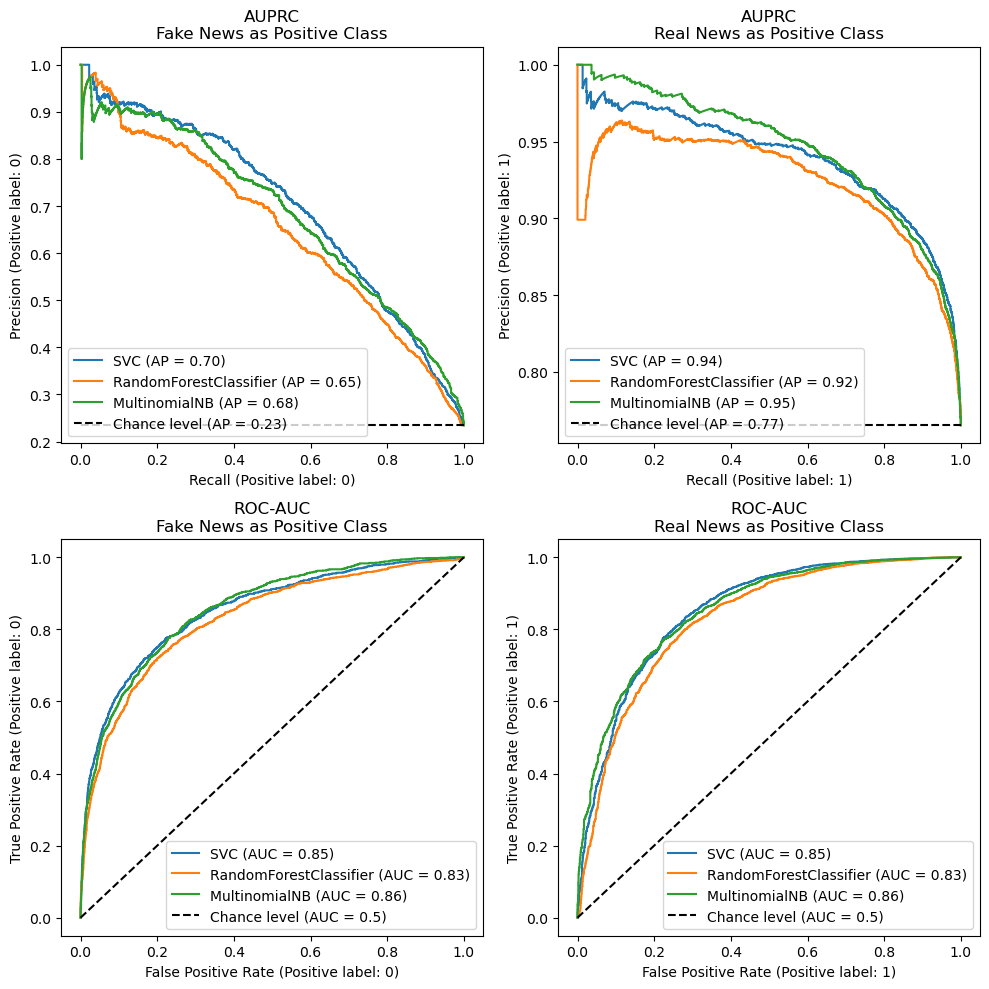

In [108]:
# Create plot canvas with subplot spaces
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# AUPRC
print('Average Precision SVC (fake news):',
    PrecisionRecallDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0]).average_precision)

print('Average Precision RF (fake news):',
    PrecisionRecallDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0]).average_precision)

print('Average Precision MNB (fake news):',
    PrecisionRecallDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[0, 0],
    plot_chance_level=True).average_precision)

print('Average Precision SVC (real news):',
    PrecisionRecallDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1]).average_precision)

print('Average Precision RF (real news):',
    PrecisionRecallDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1]).average_precision)

print('Average Precision MNB (real news):',
    PrecisionRecallDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[0, 1],
    plot_chance_level=True).average_precision)

axs[0, 0].set_title('AUPRC\nFake News as Positive Class')
axs[0, 1].set_title('AUPRC\nReal News as Positive Class')


# AUC
RocCurveDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0])

RocCurveDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0])

RocCurveDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[0], ax=axs[1, 0],
    plot_chance_level=True)

RocCurveDisplay.from_estimator(
    svc, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1])

RocCurveDisplay.from_estimator(
    rf, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1])

RocCurveDisplay.from_estimator(
    mnb, X_test_tfidf, y_test, pos_label=mnb.classes_[1], ax=axs[1, 1],
    plot_chance_level=True)

axs[1, 0].set_title('ROC-AUC\nFake News as Positive Class')
axs[1, 1].set_title('ROC-AUC\nReal News as Positive Class')

plt.tight_layout()